### Import Required Libraries

In [1]:
import string
import re
import numpy
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt

pd.set_option('display.max_colwidth', 200)

### Read Data

In [2]:
import pandas as pd  
data=pd.read_table('cmn.txt', header=None)
df=data.iloc[:,:2].sample(8000)
df

,0,1
14569,Do you still buy lottery tickets?,你還買彩票嗎？
21599,Tom waited for Mary in front of the warehouse.,湯姆在倉庫前等瑪麗。
13964,Long hair is out of fashion now.,长发现在过时了。
15698,Did you drive her home last night?,昨晚你把她送回家了吗？
19006,The number of cars is on the increase.,汽车的数量在增长。
...,...,...
18759,He's opposed to racial discrimination.,他反对种族歧视。
22086,It was ten years ago that he first came to Japan.,他第一次來到日本是在十年前。
4749,Nobody understands me.,没有人理解我。
16328,The river's water level has risen.,河的水位上升了。


In [3]:
eng_chinese=df.values

In [4]:
eng_chinese[10:15]

array([['Close the door, please.', '請關門。'],
       ['Leave the room as it is.', '保留原狀地離開房間。'],
       ['I wish she had come last night.', '但願她昨晚來就好了。'],
       ['People have two legs.', '人有两只脚。'],
       ['Guess what he told me.', '猜猜看他告訴了我什麼。']], dtype=object)

In [5]:
data=eng_chinese.copy()

In [6]:
# Remove punctuation
data[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in data[:,0]]
data[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in data[:,1]]

In [7]:
data[2]

array(['Long hair is out of fashion now', '长发现在过时了。'], dtype=object)

In [8]:
# convert to lowercase
for i in range(len(data)):
    data[i,0] = data[i,0].lower()  
    

In [9]:
data

array([['do you still buy lottery tickets', '你還買彩票嗎？'],
       ['tom waited for mary in front of the warehouse', '湯姆在倉庫前等瑪麗。'],
       ['long hair is out of fashion now', '长发现在过时了。'],
       ...,
       ['nobody understands me', '没有人理解我。'],
       ['the rivers water level has risen', '河的水位上升了。'],
       ['where are your things', '你的東西在哪裡']], dtype=object)

#### Text to Sequence Conversion

convert both the input and the output sentences into integer sequences of fixed length to feed the sequence2sequence model

In [10]:
# empty lists
eng_l = []
chi_l = []

# populate the lists with sentence lengths
for i in data[:,0]:
    eng_l.append(len(i.split()))

for i in data[:,1]:
    chi_l.append(len(i))

In [11]:
length_df = pd.DataFrame({'eng':eng_l, 'chinese':chi_l})

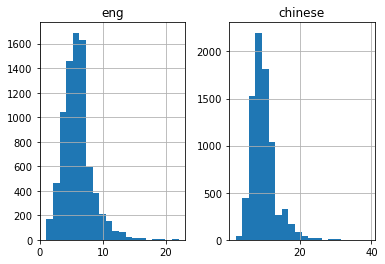

In [12]:
length_df.hist(bins=20)
plt.show()

In [13]:
print(length_df['eng'].mean(), length_df['chinese'].mean())

6.18 9.795125


In [14]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [15]:
# prepare english tokenizer
eng_tokenizer = tokenization(data[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 7
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 4150


In [16]:
# prepare chinese tokenizer
chi_tokenizer = tokenization(data[:, 1])
chi_vocab_size = len(chi_tokenizer.word_index) + 1

chi_length = 10
print('chinese Vocabulary Size: %d' % chi_vocab_size)

chinese Vocabulary Size: 7772


Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [17]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

### Model Building

In [65]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.2)

In [66]:
## Encoder
# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, train[:, 0])
trainY = encode_sequences(chi_tokenizer, chi_length, train[:, 1])

# prepare validation data
testX = encode_sequences(eng_tokenizer, eng_length, test[:, 0])
testY = encode_sequences(chi_tokenizer, chi_length, test[:, 1])

## Modeling-define  Seq2Seq model architecture
* using an Embedding layer and an LSTM layer as our encoder
* Use LSTM layer followed by a Dense layer as the decoder.  

In [67]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(TimeDistributed(Dense(out_vocab, activation='softmax')))
    return model

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [68]:
model = build_model(eng_vocab_size, chi_vocab_size, eng_length, chi_length,1000)
rms = optimizers.RMSprop(lr=0.0001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [69]:
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=10, batch_size=32, 
          validation_split = 0.2,
          verbose=1)

Epoch 1/10
160/160 [==============================] - 182s 1s/step - loss: 1.6080 - val_loss: 0.9432
Epoch 2/10
160/160 [==============================] - 197s 1s/step - loss: 0.9086 - val_loss: 0.9559
Epoch 3/10
160/160 [==============================] - 197s 1s/step - loss: 0.8970 - val_loss: 0.9741
Epoch 4/10
160/160 [==============================] - 201s 1s/step - loss: 0.8898 - val_loss: 0.9912
Epoch 5/10
160/160 [==============================] - 213s 1s/step - loss: 0.8828 - val_loss: 1.0023
Epoch 6/10
160/160 [==============================] - 216s 1s/step - loss: 0.8743 - val_loss: 1.0221
Epoch 7/10
160/160 [==============================] - 238s 1s/step - loss: 0.8635 - val_loss: 1.0488
Epoch 8/10
160/160 [==============================] - 244s 2s/step - loss: 0.8549 - val_loss: 1.0558
Epoch 9/10
160/160 [==============================] - 230s 1s/step - loss: 0.8509 - val_loss: 1.0591
Epoch 10/10
160/160 [==============================] - 230s 1s/step - loss: 0.8504 - val_lo

Let's compare the training loss and the validation loss.

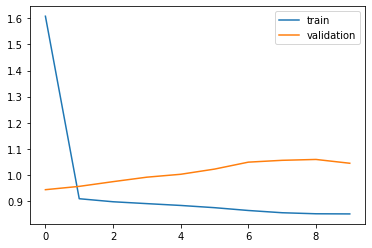

In [70]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [71]:
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

In [72]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [73]:
# convert predictions into text (chinese)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], chi_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], chi_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [37]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pred_df.head(15)

,actual,predicted
0,the board unanimously decided to appoint her as ceo,是在这点上我们的意见有分歧。
1,one of my bags is missing,禮貌過度是煩人的。
2,if we dont hurry well be late,我無法再忍受這個噪音了。
3,hell come on foot or by bicycle,自从他离开去法国，已经有两个月了。
4,who discovered radium,誰在玩？
5,can you really swim,你为什么一个人？
6,could you lend me the book,你完成工作了吗？
7,i am not a witch,我没有猫。
8,english is difficult to learn,英語在大部份的國家被教授。
9,i asked him to help me,做你認為正確的事。


In [27]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})
pred_df.head(15)

,actual,predicted
0,the board unanimously decided to appoint her as ceo,我已婚。
1,one of my bags is missing,
2,if we dont hurry well be late,我們住在一棟有三間臥室的房子。
3,hell come on foot or by bicycle,那只是你的想象。
4,who discovered radium,我喜歡運動。
5,can you really swim,
6,could you lend me the book,你们午饭吃了什么？
7,i am not a witch,我在树林里迷路了。
8,english is difficult to learn,
9,i asked him to help me,我在树林里迷路了。


In [74]:
pred_df.sample(15)

,actual,predicted
801,tom made his servants eat in the dark,我是据我所知最懒的人。
969,he must be the principal,他敲了門。
896,do you really believe in ghosts,我下周日不在家。
251,the towel wasnt useful at all,他沒有通過他的駕駛考試。
200,whats this,那是什么？
452,i cant remember how to go there,她的想法比你的好。
94,tom likes science fiction,草莓在哪裡？
484,she asked how to cook the fish,你认为他能够胜任这个任务吗
666,this novel is boring,她是个倔强的女孩。
804,ostriches cant fly,她也許會來。
